In [55]:
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(40)

""""
Parameters used :
r : risk free rate 
sigma : volatility of the stock 
X0 : initial stock price
T : maturity date
n : number of simulation 
m : step in Euler scheme
A reverse convertible can be seen as a short down an in put (barrier option) and a guaranteed coupon received at maturity.
"""

r,sigma,X0,T,n,m = 0 , 0.2 , 100 , 1 , 10**4, 100 

"""
Parameters of the DI Put option and the coupon :

K : strike of the put option (usually ATM)
H : barrier (usually 50-80% of X0)
C : coupon rate (usually 6%)
P : principal invested
"""
K , H , C , P = 100 , 80 , 0.1 , 100

#reverse convertible = short down and in put + guaranted coupon 
# payoff reverse convertible= -(K-S_T)+*indatrice(min(St)<=H) + C 

In [56]:
# Function to generate paths using the Euler-Maruyama method
def Euler_X(X0=100, sigma=0.2, T=1, m=100, n=10**4, W=None):
    if W is None:
        W = np.random.randn(n, m)
    return X0 * np.cumprod(1 + r * T/m + sigma * np.sqrt(T/m) * W, axis=1)

# Function to estimated the price of the option by Monte Carlo simulations
def MC_RCbarrier(X0=100, sigma=0.2, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, W=None):
    if W is None:
        W = np.random.randn(n, m)
    X = Euler_X(X0, sigma, T, m, n, W) # Simulations of the n Black-Scholes paths of the underlying
    X = np.hstack((X0 * np.ones((n, 1)), X))
    min_X = np.min(X, axis=1)
    payoff_arr = -(np.maximum(K - X[:, -1], 0) * (min_X <= H)) + (1+P)*C # Payoff of the RC_barrier for each simulation
    estimator = np.mean(payoff_arr * np.exp(-r * T)) # Price estimator = discounted expectation of the payoff
    std_error = np.std(payoff_arr) / np.sqrt(n) # Standard error of the MC estimator
    return estimator, std_error


estim_1, std_error_1 = MC_RCbarrier()
print("Estimator for m = 100 : ", estim_1)
print("Confidence interval for m = 100 : [", estim_1 - 1.96*std_error_1, " ; ", estim_1 + 1.96*std_error_1, "].")

Estimator for m = 100 :  10.07422730965395
Confidence interval for m = 100 : [ 10.051626233036275  ;  10.096828386271623 ].


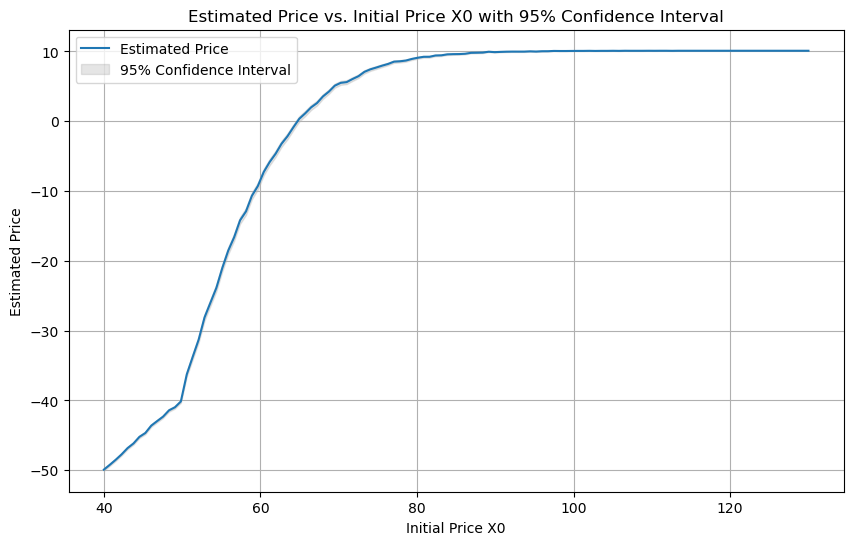

In [91]:
# Values of X0 to consider
X0_values = np.linspace(40, 130, 120)

# Calculate the estimated price and standard error for each X0
estimates = []
std_errors = []
for element in X0_values:
    estim, std_err = MC_RCbarrier(X0=element)
    estimates.append(estim)
    std_errors.append(std_err)

# Calculate the upper and lower bounds of the 95% confidence interval
upper_bounds = [est + 1.96 * err for est, err in zip(estimates, std_errors)]
lower_bounds = [est - 1.96 * err for est, err in zip(estimates, std_errors)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X0_values, estimates, label='Estimated Price')
plt.fill_between(X0_values, lower_bounds, upper_bounds, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Estimated Price vs. Initial Price X0 with 95% Confidence Interval')
plt.xlabel('Initial Price X0')
plt.ylabel('Estimated Price')
plt.legend()
plt.grid(True)
plt.show()

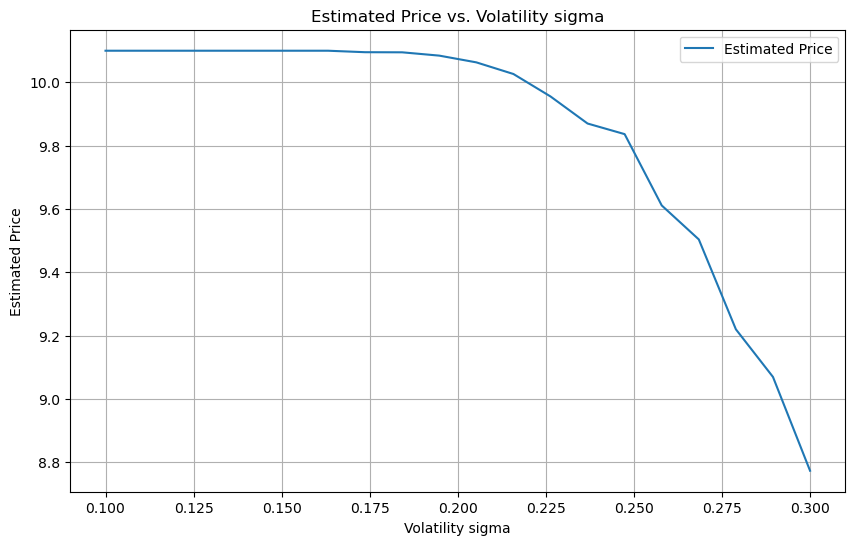

In [78]:
# Values of sigma to consider
sigma_values = np.linspace(0.1, 0.3, 20)

# Calculate the estimated price for each sigma
estimates = [MC_RCbarrier(sigma=element)[0] for element in sigma_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sigma_values, estimates, label='Estimated Price')
plt.title('Estimated Price vs. Volatility sigma')
plt.xlabel('Volatility sigma')
plt.ylabel('Estimated Price')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
def calculate_delta(X0=100, sigma=0.2, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, delta_X=1, W=None):
    if W is None:
        W = np.random.randn(n, m)
    price_up = MC_RCbarrier(X0+delta_X, sigma, T, K, H, C, P, m, n, W)[0]
    price_down = MC_RCbarrier(X0-delta_X, sigma,  T, K, H, C, P, m, n, W)[0]
    return (price_up - price_down) / (2 * delta_X)

def calculate_gamma(X0=100, sigma=0.2, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, delta_X=1, W=None):
    if W is None:
        W = np.random.randn(n, m)
    price_up = MC_RCbarrier(X0+delta_X, sigma, T, K, H, C, P, m, n, W)[0]
    price_down = MC_RCbarrier(X0-delta_X, sigma,  T, K, H, C, P, m, n, W)[0]
    base_price = MC_RCbarrier(X0, sigma,  T, K, H, C, P, m, n, W)[0]
    return (price_up - 2 * base_price + price_down) / (delta_X ** 2)

def calculate_vega(X0=100, sigma=0.2, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, delta_sigma=0.05, W=None):
    if W is None:
        W = np.random.randn(n, m)
    base_price = MC_RCbarrier(X0, sigma, T, K, H, C, P, m, n, W)[0]
    price_vol_up = MC_RCbarrier(X0, sigma+delta_sigma, T, K, H, C, P, m, n, W)[0]
    return (price_vol_up - base_price) / delta_sigma


In [83]:
Z = np.random.randn(n, m)

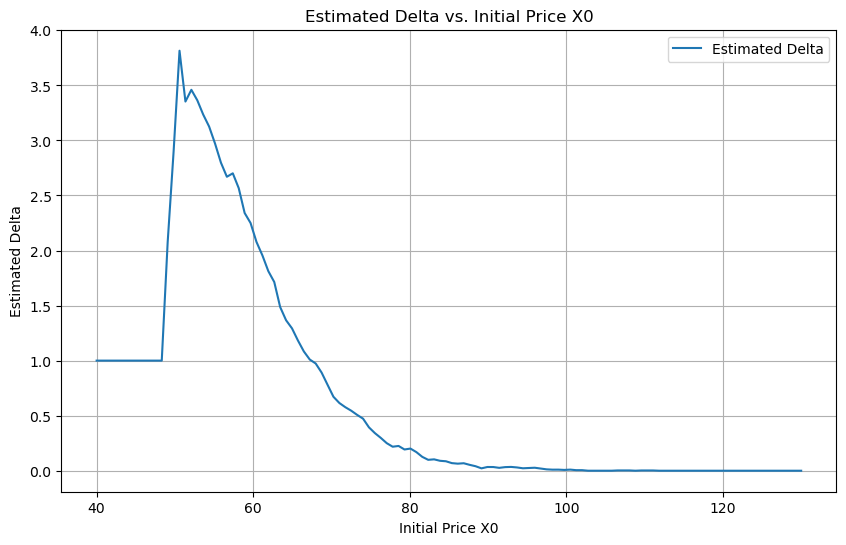

In [84]:
# Calculate the estimated Delta for each X0
deltas = [calculate_delta(X0=element, W=Z) for element in X0_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X0_values, deltas, label='Estimated Delta')
plt.title('Estimated Delta vs. Initial Price X0')
plt.xlabel('Initial Price X0')
plt.ylabel('Estimated Delta')
plt.legend()
plt.grid(True)
plt.show()

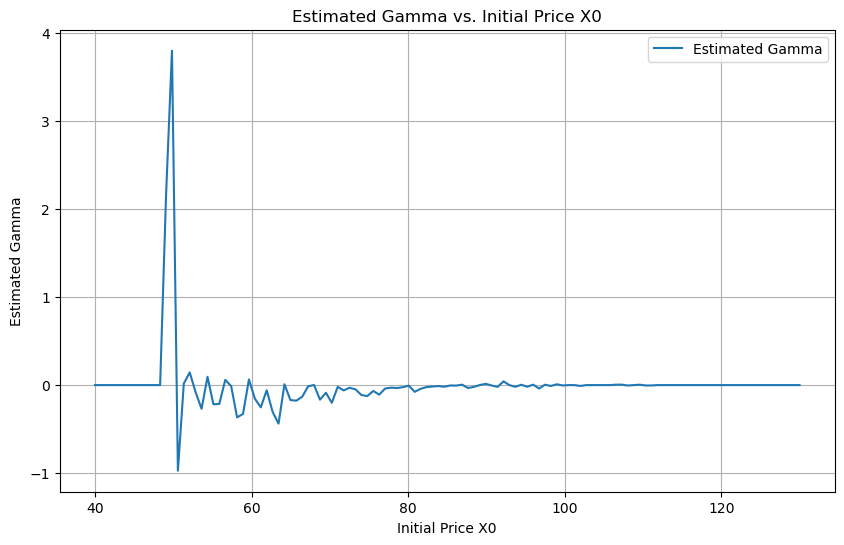

In [85]:
# Calculate the estimated Gamma for each X0
gammas = [calculate_gamma(X0=element, W=Z) for element in X0_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X0_values, gammas, label='Estimated Gamma')
plt.title('Estimated Gamma vs. Initial Price X0')
plt.xlabel('Initial Price X0')
plt.ylabel('Estimated Gamma')
plt.legend()
plt.grid(True)
plt.show()

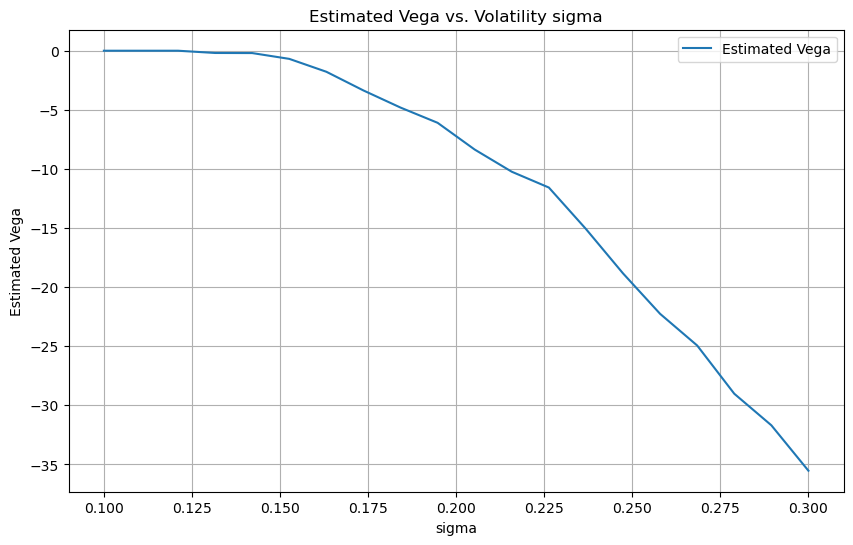

In [90]:
# Calculate the estimated vega for each sigma
vegas = [calculate_vega(sigma=element, W=Z) for element in sigma_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sigma_values, vegas, label='Estimated Vega')
plt.title('Estimated Vega vs. Volatility sigma')
plt.xlabel('sigma')
plt.ylabel('Estimated Vega')
plt.legend()
plt.grid(True)
plt.show()

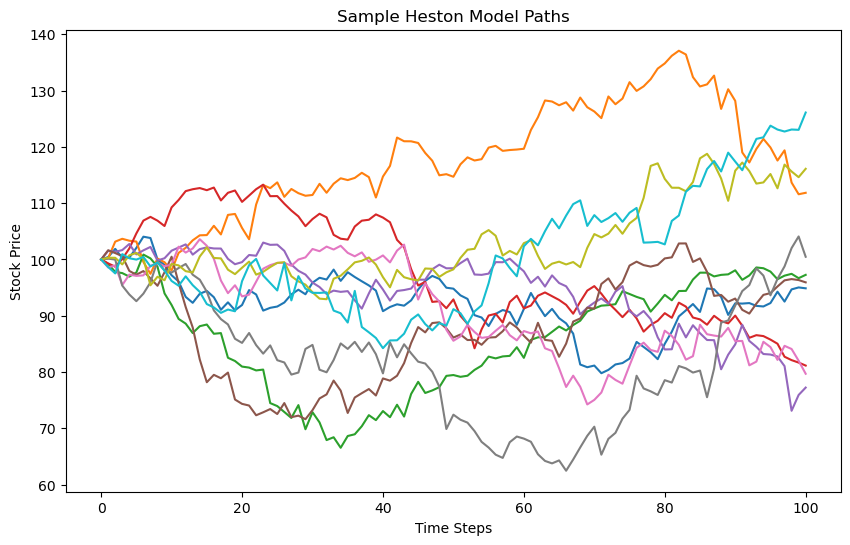

In [96]:
# Parameters relevant only for the Heston model
V0 = 0.04      # Initial variance
kappa = 1.5    # Speed of mean reversion for variance
theta = 0.06   # Long-term variance
sigmav = 0.3   # Volatility of volatility
rho = -0.6     # Correlation between the two Brownian motions

def Heston_Simulator(X0=100, V0=0.04, kappa=1.5, theta=0.06, sigmav=0.3, rho=-0.6, r=0, T=1, m=100, n=10**4, Z=None):
    dt = T / m
    X = np.zeros((n, m+1))
    V = np.zeros((n, m+1))
    X[:, 0] = X0
    V[:, 0] = V0

    # Correlated Brownian motions
    if Z is None:
        Z = np.random.normal(size=(2, n, m))
    L = np.array([[1, 0], [rho, np.sqrt(1 - rho**2)]])
    W = np.tensordot(L, Z, axes=([1],[0]))
    dWs = np.sqrt(dt) * W[0,:,:]
    dWv = np.sqrt(dt) * W[1,:,:]

    for t in range(m):
        # Ensure variance stays positive
        Vt = np.maximum(V[:, t], 0)
        
        # Euler-Maruyama for the variance process
        V[:, t+1] = V[:, t] + kappa * (theta - Vt) * dt + sigmav * np.sqrt(Vt) * dWv[:, t]
        
        # Euler-Maruyama for the stock process
        X[:, t+1] = X[:, t] + r * X[:, t] * dt + np.sqrt(Vt) * X[:, t] * dWs[:, t]

    return X

# Simulate the trajectories
heston_paths = Heston_Simulator()
plt.figure(figsize=(10, 6))
for i in range(10):  # Plot the first 10 simulated paths
    plt.plot(heston_paths[i])
plt.title('Sample Heston Model Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()


In [98]:
def MC_RCbarrier_Heston(X0=100, V0=0.04, kappa=1.5, theta=0.06, sigmav=0.3, rho=-0.6, r=0, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, Z=None):
    # Generate the paths using the Heston model
    X = Heston_Simulator(X0, V0, kappa, theta, sigmav, rho, r, T, m, n, Z)
    
    # Calculate the minimum value of each path
    min_X = np.min(X, axis=1)

    # Calculate the payoff for each simulation
    payoff_arr = -(np.maximum(K - X[:, -1], 0) * (min_X <= H)) + (1 + P) * C

    # Calculate the estimator and standard error
    estimator = np.mean(payoff_arr * np.exp(-r * T))
    std_error = np.std(payoff_arr) / np.sqrt(n)
    
    return estimator, std_error


In [100]:
estim_2, std_error_2 = MC_RCbarrier_Heston()
print("Estimator for m = 100 : ", estim_2)
print("Confidence interval for m = 100 : [", estim_2 - 1.96*std_error_2, " ; ", estim_2 + 1.96*std_error_2, "].")

Estimator for m = 100 :  9.232115541712712
Confidence interval for m = 100 : [ 9.101381165337289  ;  9.362849918088136 ].


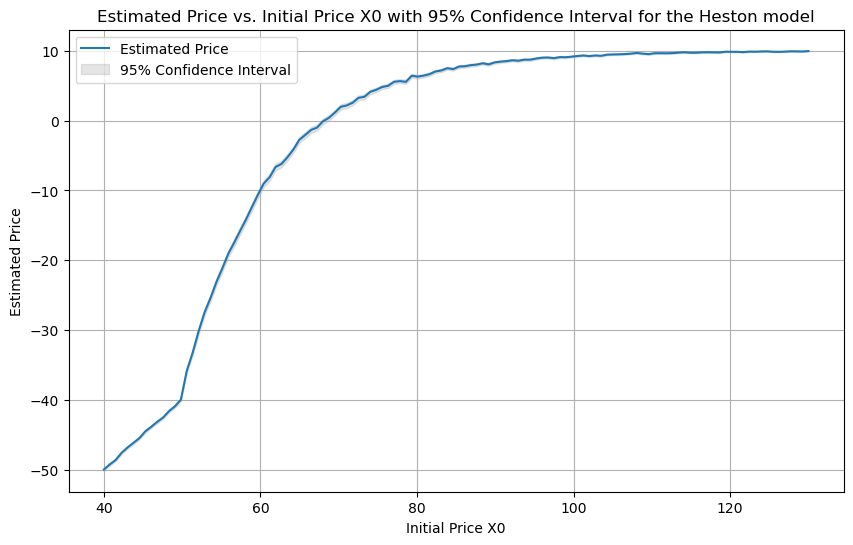

In [99]:
# Calculate the estimated price and standard error for each X0
estimates_heston = []
std_errors_heston = []
for element in X0_values:
    estim, std_err = MC_RCbarrier_Heston(X0=element)
    estimates_heston.append(estim)
    std_errors_heston.append(std_err)

# Calculate the upper and lower bounds of the 95% confidence interval
upper_bounds_heston = [est + 1.96 * err for est, err in zip(estimates_heston, std_errors_heston)]
lower_bounds_heston = [est - 1.96 * err for est, err in zip(estimates_heston, std_errors_heston)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X0_values, estimates_heston, label='Estimated Price')
plt.fill_between(X0_values, lower_bounds_heston, upper_bounds_heston, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Estimated Price vs. Initial Price X0 with 95% Confidence Interval for the Heston model')
plt.xlabel('Initial Price X0')
plt.ylabel('Estimated Price')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
def calculate_delta_Heston(X0=100, V0=0.04, kappa=1.5, theta=0.06, sigmav=0.3, rho=-0.6, r=0, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, delta_X=1, Z=None):
    if Z is None:
        Z = np.random.normal(size=(2, n, m))
    price_up = MC_RCbarrier_Heston(X0+delta_X, V0, kappa, theta, sigmav, rho, r, T, K, H, C, P, m, n, Z)[0]
    price_down = MC_RCbarrier_Heston(X0-delta_X, V0, kappa, theta, sigmav, rho, r, T, K, H, C, P, m, n, Z)[0]
    return (price_up - price_down) / (2 * delta_X)

def calculate_gamma_Heston(X0=100, V0=0.04, kappa=1.5, theta=0.06, sigmav=0.3, rho=-0.6, r=0, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, delta_X=1, Z=None):
    if Z is None:
        Z = np.random.normal(size=(2, n, m))
    price_up = MC_RCbarrier_Heston(X0+delta_X, V0, kappa, theta, sigmav, rho, r, T, K, H, C, P, m, n, Z)[0]
    price_down = MC_RCbarrier_Heston(X0-delta_X, V0, kappa, theta, sigmav, rho, r, T, K, H, C, P, m, n, Z)[0]
    base_price = MC_RCbarrier_Heston(X0, V0, kappa, theta, sigmav, rho, r, T, K, H, C, P, m, n, Z)[0]
    return (price_up - 2 * base_price + price_down) / (delta_X ** 2)

def calculate_vega_Heston(X0=100, V0=0.04, kappa=1.5, theta=0.06, sigmav=0.3, rho=-0.6, r=0, T=1, K=100, H=50, C=0.1, P=100, m=100, n=10**4, delta_sigmav=0.05, Z=None):
    if Z is None:
        Z = np.random.normal(size=(2, n, m))
    base_price = MC_RCbarrier_Heston(X0, V0, kappa, theta, sigmav, rho, r, T, K, H, C, P, m, n, Z)[0]
    price_vol_up = MC_RCbarrier_Heston(X0, V0, kappa, theta, sigmav+delta_sigmav, rho, r, T, K, H, C, P, m, n, Z)[0]
    return (price_vol_up - base_price) / delta_sigmav


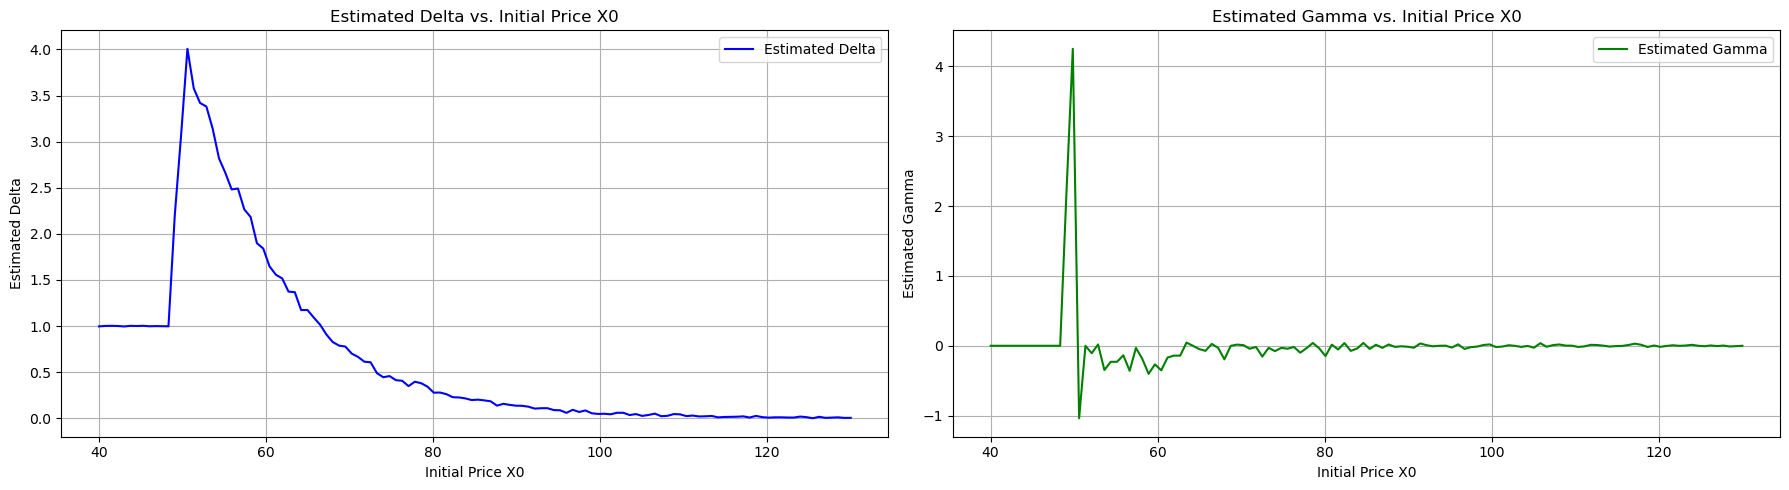

In [103]:
# Calculate the estimated Delta, Gamma, and Vega for each X0
deltas = [calculate_delta_Heston(X0=element) for element in X0_values]
gammas = [calculate_gamma_Heston(X0=element) for element in X0_values]

# Create a figure and a set of subplots
plt.figure(figsize=(18, 5))

# Delta Plot
plt.subplot(1, 2, 1)  # 1 row, 3 columns, 1st subplot
plt.plot(X0_values, deltas, label='Estimated Delta', color='blue')
plt.title('Estimated Delta vs. Initial Price X0')
plt.xlabel('Initial Price X0')
plt.ylabel('Estimated Delta')
plt.legend()
plt.grid(True)

# Gamma Plot
plt.subplot(1, 2, 2)  # 1 row, 3 columns, 2nd subplot
plt.plot(X0_values, gammas, label='Estimated Gamma', color='green')
plt.title('Estimated Gamma vs. Initial Price X0')
plt.xlabel('Initial Price X0')
plt.ylabel('Estimated Gamma')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()